<a href="https://colab.research.google.com/github/pollyjuice74/5G-Decoder/blob/main/LTD_model_reg_LDPC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Transformer Decoder on regular LDPC codes.

This note book walks you through the code on how to run the decoder.

In [2]:
# Imports
import tensorflow as tf
import random
import numpy as np
import time
import os

from sionna.fec.utils import generate_reg_ldpc, load_parity_check_examples, LinearEncoder, gm2pcm
from sionna.utils.plotting import PlotBER
from sionna.fec.ldpc import LDPCBPDecoder

In [ ]:
# Checking GPUs are recognized
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

## LDPC Code
Here we specify code parameters such as `c`, `v` and `n`, instantiate the `LinearEncoder` and `LDPCBPDecoder`, then check that `syndorme = 0`.

Loading LDPC code
Setting n to:  150
Number of edges (VN perspective):  450
Number of edges (CN perspective):  450
Generated regular (3,6) LDPC code of length n=150
Code rate is r=0.500.
(75, 150) (2, 150)


2025-01-17 15:41:27.986502: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-17 15:41:27.986624: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-17 15:41:27.986668: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

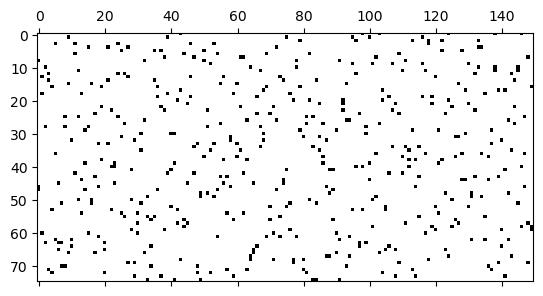

In [3]:
print("Loading LDPC code")
pcm, k, n, coderate = generate_reg_ldpc(v=3,
                                        c=6,
                                        n=150,
                                        allow_flex_len=True,
                                        verbose=True)

# pcm = tf.cast(pcm, dtype=tf.int32)
encoder = LinearEncoder(pcm, is_pcm=True, dtype=tf.int32)
bp_decoder = LDPCBPDecoder(pcm,
                           num_iter=1,) # BP iterations

batch_size = 2  # For multiple codewords
b = tf.random.uniform((batch_size, k), minval=0, maxval=2, dtype=tf.int32)
c = encoder(b)
print(pcm.shape, c.shape)
pcm @ tf.transpose(c) % 2 # syndrome check

## Training and optimal hyperparameters for Regular Transformer
Here we set training parameters and have a for loop for testing optimal model hyperparameters.

In [ ]:
from src.args import Args
from src.decoder import Decoder
from src.e2e_model import E2EModel

from src.utils import train_dec
import gc


# args for decoder
linear = False
args = Args()
# training
args.lr = 1e-5
args.batch_size = 100
args.epochs = 500000

args.ebno_db_min = 0 # training with higher ebno db leads to better quicker results
args.ebno_db_max = 8

args.code.H = pcm
args.m, args.n = pcm.shape
args.k = k

# Loop for testing optimal hyperparams
for t_layers in [6]:
    for d_model in [128]:
        args.t_layers = t_layers
        args.d_model = d_model

        transformer_decoder = Decoder(args, linear=linear, verbose=False) # Regular Transformer Diffusion (LTD) Decoder

        e2e_trans_dec = E2EModel(encoder, transformer_decoder, k, n)

        train_dec(e2e_trans_dec,
                args,
                file_name=f'ECCT_pcm_{args.m}_{args.n}_Tlayers{args.t_layers}_dims{args.d_model}/weights', # 'weights' is not a file just a place holder
                load_decoder_weights=False)
        
        del e2e_trans_dec # Delete model to free up space and prevent kernel crash
        gc.collect()  

## Plotting performance
Here we use Sionna's  `PlotBER` to evaluate performance and compare against Belief Propagation decoding.

Best BER found: 0.0300781
Successfully restored weights from ./Decoder_weights/ECC_weights/ECCT_pcm_32_64_Tlayers6_dims128/best_weights_ber_3.00781e-02-1
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.5570e-01 | 1.0000e+00 |        5979 |       38400 |          600 |         600 |         0.7 |reached target block errors
      1.0 | 1.2768e-01 | 1.0000e+00 |        4903 |       38400 |          600 |         600 |         0.0 |reached target block errors
      2.0 | 9.5964e-02 | 9.9333e-01 |        3685 |       38400 |          596 |         600 |         0.0 |reached target block errors
      3.0 | 6.5443e-02 | 9.7500e-01 |        2513 |       38400 |          585 |         600 |         0.0 |reached target block errors
      4.0 | 4.1016e-02 | 9.0500e-01 |        15

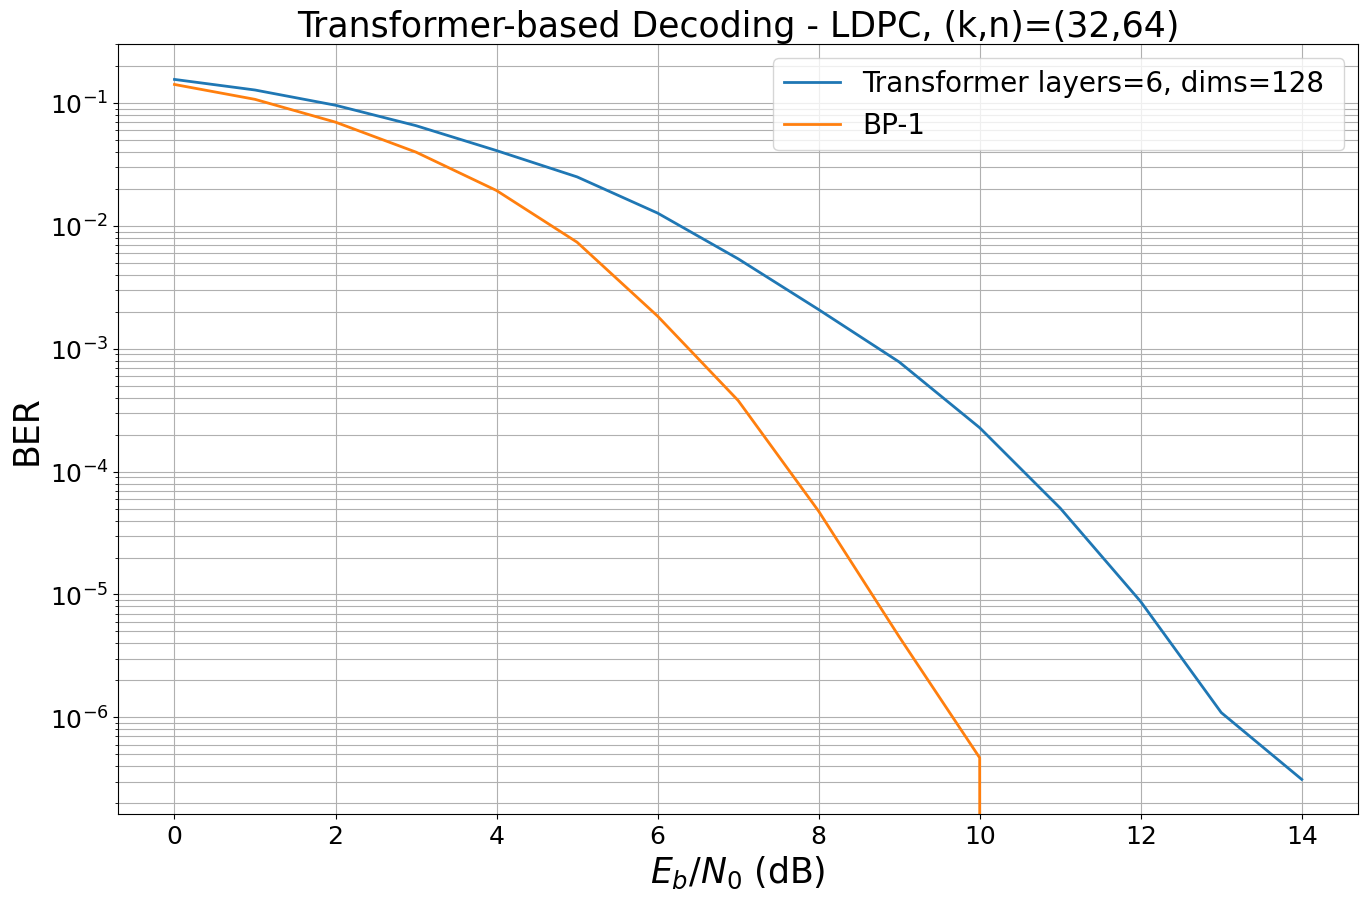

In [ ]:
from src.utils import *


ber_plot = PlotBER(f"Transformer-based Decoding - LDPC, (k,n)=({e2e_trans_dec._k},{e2e_trans_dec._n})")
ebno_dbs = np.arange(args.ebno_db_min,
                     args.ebno_db_max,
                     args.ebno_db_stepsize)

# Loop to test optimal hyperparameters
for t_layers in [8]:
    for d_model in [96]:
        args.t_layers = t_layers
        args.d_model = d_model

        # Regular Transformer Decoder      
        transformer_decoder = Decoder(args, linear=linear, verbose=False)

        # Initialize model
        e2e_trans_dec = E2EModel(encoder, transformer_decoder, k, n)

        # Load model weights
        dir_path = f"./Decoder_weights/ECC_weights/ECCT_pcm_{args.m}_{args.n}_Tlayers{t_layers}_dims{d_model}/"
        _, best_file = parse_best_loss_value_from_filename(dir_path)
        best_weights_path = os.path.join(dir_path, best_file)

        load_weights(e2e_trans_dec, best_weights_path)

        # and run the BER simulations
        ber_plot.simulate(e2e_trans_dec,
                        ebno_dbs=ebno_dbs,
                        batch_size=args.mc_batch_size,
                        num_target_block_errors=500,
                        legend=f"Transformer layers={e2e_trans_dec._decoder.t_layers}, dims={e2e_trans_dec._decoder.dims} ",
                        soft_estimates=False,
                        max_mc_iter=args.mc_iters,
                        forward_keyboard_interrupt=False,
                        show_fig=False);

# Finally compare against BP decoding
e2e_bp = E2EModel(encoder,
                  bp_decoder,
                  k,
                  n,
                  rate_matching=True)

ber_plot.simulate(e2e_bp,
                  ebno_dbs=ebno_dbs,
                  batch_size=args.mc_batch_size,
                  num_target_block_errors=500,
                  legend=f"BP-{bp_decoder._num_iter.numpy()}",
                  soft_estimates=True,
                  max_mc_iter=args.mc_iters,
                  forward_keyboard_interrupt=False,
                  show_fig=True);

## Training and optimal hyperparameters for Linear Transformer
Here we set training parameters, we have a for loop for testing optimal model hyperparameters and another inner loop for mask divisions.

In [ ]:
from src.args import Args
from src.decoder import Decoder
from src.e2e_model import E2EModel

from src.utils import train_dec
import gc


# args for decoder
linear = False
args = Args()
# training
args.lr = 1e-5
args.batch_size = 100
args.epochs = 500000

args.ebno_db_min = 0 # training with higher ebno db leads to better quicker results
args.ebno_db_max = 8

args.code.H = pcm
args.m, args.n = pcm.shape
args.k = k

# Loop for testing optimal hyperparams
for t_layers in [8]:
    for d_model in [64]:
        # Model args
        args.t_layers = t_layers
        args.d_model = d_model

        # mask shape divided by mask_div on one dimention, the computes gcd for k_proj shape
        for mask_div in range(2, 3): 
            args.mask_division_shape = mask_div

            # Linear Transformer 5G Decoder (LTD)
            lin_transformer_decoder = Decoder( encoder, args, linear=linear, verbose=False) 

            # Initialize model
            e2e_lin_tran = E2EModel(encoder, lin_transformer_decoder, k, n)

            # get best weights function
            file_name = f'LECCT_maskdiv{mask_div}_pcm_{args.m}_{args.n}_Tlayers{args.t_layers}_dims{args.d_model}/weights' # 'weights' is not a file just a place holder

            train_dec(e2e_lin_tran,
                    args,
                    file_name=file_name,
                    load_decoder_weights=True,)
            
            del e2e_lin_tran # Delete model to free up space and prevent kernel crash
            gc.collect()      

# Comparing all decoders
Here we compare performance of the Tranformer, Linear Transformer and Belief Propagation.

In [ ]:
from src.utils import *

# Speed to BER trade off graph
ber_plot = PlotBER(f"Linear Transformer-based 5G Decoding against Regular Transformer-based 5G Decoding - LDPC, (k,n)=({k_pcm},{n_pcm})")
args.mc_batch_size = 100
args.mc_iters = 1000000

args.ebno_db_min = 2
args.ebno_db_max = 5
args.ebno_db_stepsize = 1

ebno_dbs = np.arange(args.ebno_db_min,
                     args.ebno_db_max,
                     args.ebno_db_stepsize)

# Loop for testing optimal hyperparams
for t_layers in [8]:
    for d_model in [64]:
        # Model args
        args.t_layers = t_layers
        args.d_model = d_model
        
        # mask shape divided by mask_div on one dimention, the computes gcd for k_proj shape
        for mask_div in range(2,3):
                args.mask_division_shape = mask_div
                
                # Linear Transformer 5G Decoder (LTD) 
                lin_transformer_decoder = Decoder( encoder, args, linear=linear, verbose=False ) 

                # Initialize model
                e2e_lin_tran = E2EModel(encoder, lin_transformer_decoder, k, n)

                 # Load model weights
                file_name = f'LECCT_maskdiv{mask_div}_pcm_{args.m}_{args.n}_Tlayers{args.t_layers}_dims{args.d_model}/weights' # 'weights' is not a file just a place holder
                # Initializing model
                args.epochs = 1
                train_dec(e2e_lin_tran,
                        args,
                        file_name=file_name,
                        load_decoder_weights=True,)

                # and run the BER simulations
                ber_plot.simulate(e2e_lin_tran,
                                ebno_dbs=ebno_dbs,
                                batch_size=args.mc_batch_size,
                                num_target_block_errors=500,
                                legend=f"Linear Transformer mask_div={mask_div}, layers={e2e_lin_tran._decoder.t_layers}, dims={e2e_lin_tran._decoder.dims}",
                                soft_estimates=False,
                                max_mc_iter=args.mc_iters,
                                forward_keyboard_interrupt=False,
                                show_fig=False);

# Regular Transformer 5G Decoder (LTD) 
linear = False
args.t_layers = 6
args.d_model = 128
transformer_decoder = Decoder( encoder, args, linear=linear, verbose=False )
# Initialize model
e2e_reg_tran = E2EModel(encoder, transformer_decoder, k, n)

# Load model weights
dir_path = f"./Decoder_weights/ECC_weights/ECCT_pcm_{args.m}_{args.n}_Tlayers{args.t_layers}_dims{args.d_model}/"
_, best_file = parse_best_loss_value_from_filename(dir_path)
best_weights_path = os.path.join(dir_path, best_file)
load_weights(e2e_reg_tran, best_weights_path)

# Simulate
ber_plot.simulate(e2e_reg_tran,
                ebno_dbs=ebno_dbs,
                batch_size=args.mc_batch_size,
                num_target_block_errors=500,
                legend=f"Regular Transformer layers={e2e_reg_tran._decoder.t_layers}, dims={e2e_reg_tran._decoder.dims}",
                soft_estimates=False,
                max_mc_iter=args.mc_iters,
                forward_keyboard_interrupt=False,
                show_fig=False);

# Finally compare against 5G BP decoding
e2e_bp = E2EModel(encoder,
                  bp_decoder,
                  k,
                  n,
                  rate_matching=True)

ber_plot.simulate(e2e_bp,
                  ebno_dbs=ebno_dbs,
                  batch_size=args.mc_batch_size,
                  num_target_block_errors=500,
                  legend=f"BP-{bp_decoder._num_iter.numpy()}",
                  soft_estimates=True,
                  max_mc_iter=args.mc_iters,
                  forward_keyboard_interrupt=False,
                  show_fig=True);

# Time performance
Finally we plot out decoding times for the regular Transformer, Linear Transformer and Belief Propagation decoders.

Evaluating on 15
{'BP Decoder (iters=1)': <src.e2e_model.E2EModel object at 0x78600f5184c0>, 'Regular Transformer': <src.e2e_model.E2EModel object at 0x78600f519d50>, 'Linear Transformer (mask_div=2)': <src.e2e_model.E2EModel object at 0x78600f568460>}
Evaluating on 30
{'BP Decoder (iters=1)': <src.e2e_model.E2EModel object at 0x786056419810>, 'Regular Transformer': <src.e2e_model.E2EModel object at 0x78600cd40bb0>, 'Linear Transformer (mask_div=2)': <src.e2e_model.E2EModel object at 0x78600e1ec910>}
Evaluating on 45
Stopping - no solution found!
{'BP Decoder (iters=1)': <src.e2e_model.E2EModel object at 0x78601f546c20>, 'Regular Transformer': <src.e2e_model.E2EModel object at 0x78600f581db0>, 'Linear Transformer (mask_div=2)': <src.e2e_model.E2EModel object at 0x78600cd2d6f0>}
Evaluating on 60
{'BP Decoder (iters=1)': <src.e2e_model.E2EModel object at 0x78601a088340>, 'Regular Transformer': <src.e2e_model.E2EModel object at 0x78600d73aaa0>, 'Linear Transformer (mask_div=2)': <src.e2e_

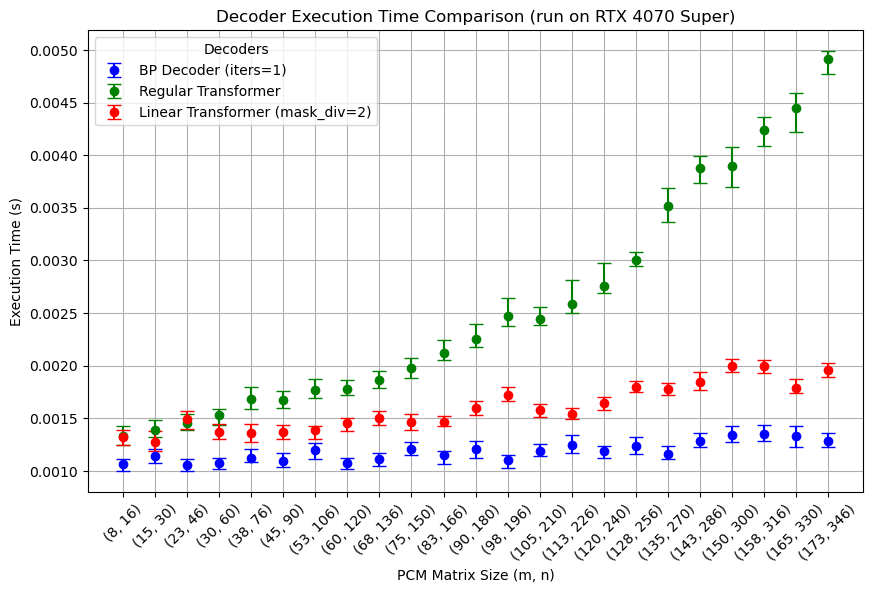

In [5]:
from src.time_comparison import decoders_comparison, plot_comparison

args = Args()
args.ns_eval = list(range(15, 350, 15))

# compare decoders
data = decoders_comparison(args, mask_divisions=range(2,3))
plot_comparison(data, colors=['blue', 'green', 'red']) # colors should match the amount of models that are being evaluated